
<h1> Data pipeline for UNDP Energy Moonshot Tracker </h1> 

This notebook executes the full data pipeline for ingesting the country-level energy project outputs alongside country metadata, data from the transparency portal API, donor information, and conversion factors based on our methodology to evaluate counts for direct and indirect beneficiaries. This data is then analyzed, visualized, and exported.

In [305]:
import pandas as pd
import os
import numpy as np
import warnings
import random
import seaborn as sns
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')
import json
from tqdm import tqdm
import ast
import countrynames
import math
from urllib.request import urlopen
import re
import xlsxwriter


<h2> Prepare data (Projects, Outputs, Donors, and Countries) </h2>

<h4> Country metadata and tracker </h4>

In [267]:

#country metadata
countryMetaRaw=pd.read_csv("../01_Input/03_Country Meta/countryMetadataInput.csv")

#tracker document
progressTracker=pd.read_csv("../01_Input/03_Country Meta/CO progress tracker.csv")

countryMetadata = pd.merge(countryMetaRaw, progressTracker, on='Country Code')

#print(countryMetadata)

countryMetadata.to_csv("../02_Output/03_Countries/countryMetadata.csv")

<h4> Create dataframes for projects and outputs </h4>

In [268]:
##analyze projects included

countryList=[]

projectDict={}
outputDict={}

file_path="../01_Input/00_CO Validation/"

for root, directories, files in os.walk(file_path):
    count=0
    for name in files:
        if "$" not in name and "DS" not in name and "Energy Projects" in name:
                        
            df=pd.read_excel(file_path+name)

            countryName=name.split(" -")[0]
            try:
                countryCode=countryMetadata.loc[countryMetadata['Country Name'] == countryName, 'Country Code'].values[0]
            except:
                countryCode="NA"
            countryList.append(countryCode)
            

            projectId="none"
            for index,row in df.iterrows():
                
                #if there is something in the id column, set the current project info
                if str(row["Project ID"])!="nan" and len(str(row["Project ID"]).strip())>0:
                    projectId=row["Project ID"]
                    #check if id works (need to update this to handle multi-ids)
                    if str(projectId).replace('.','').strip().isnumeric() or "missing" in str(projectId):
                        #print(projectId)
                        pass
                    
                    budget=0
                    if "Budget" in row:
                        budget=row["Budget"]
                    elif "Budget (USD)" in row:
                        budget=row["Budget (USD)"]
                    if "$" in str(budget):
                        budget=budget.split("$")[-1]
                    try:
                        budget=float(budget)
                    except:
                        #print(budget,countryName)
                        budget=-1##just a flag that the budget is tbd


                    title=row["Title"]
                    link=row["Link"]
                    try:
                        donors=row["Donors"]
                    except:
                        donors=""
                    
                if projectId!="none":
                    
                    count+=1

                    if str(projectId) not in projectDict:
                        projectDict[str(projectId)]={"Project ID":projectId,
                                                "Project Title":title,
                                                "Budget":budget,
                                                "Country":countryName,
                                                "Country Code":countryCode,
                                                "Link":link,
                                                "Donors":donors,
                                                "Output Count":1}
                        newOutputId=str(projectId)+"-1"
                    else:
                        projectDict[str(projectId)]["Output Count"]+=1
                        newOutputId=str(projectId)+"-"+str(projectDict[str(projectId)]["Output Count"])

                    newOutput=row
                    projectMeta=projectDict[str(projectId)]
                    newOutput["Output ID"]=newOutputId
                    newOutput["Project ID"]=projectMeta["Project ID"]
                    newOutput["Title"]=projectMeta["Project Title"]
                    newOutput["Country Code"]=countryCode
                    newOutput["Country"]=projectMeta["Country"]
                    newOutput["Link"]=projectMeta["Link"]
                    newOutput["Budget"]=projectMeta["Budget"]

                    outputDict[newOutputId]=newOutput
                else:
                    print(countryCode," - ",projectId," - ", title," - bad ID")
                            

projectDf=pd.DataFrame.from_records([*projectDict.values()])
outputDf=pd.DataFrame.from_records([*outputDict.values()])


projectDf.to_csv("../02_Output/01_Projects/projectDfValidation.csv")
outputDf.to_csv("../02_Output/02_Outputs/outputDfValidation.csv")
print(count)

SLB  -  none  -  Sustainable Cities: Ashgabat and Awaza  - bad ID
973


In [269]:
#calculate project and output stats
projectList=projectDf["Project ID"].tolist()
print(len(projectList), "projects")
print(len(outputDict), "outputs")
print(projectDf["Budget"].sum(),"budget")

340 projects
973 outputs
3822713632.424919 budget


<h2> Process dataframes (Projects, Outputs, Donors, and Countries) </h2>

<h4> Clean up outputDf </h4>

In [270]:
#keep only certain headers (need to clean data to correct names)

headers=["Project ID","Output ID","Country Code","Title","Link","Budget","Beneficiary Category","Indicator","Baseline","Target","Notes","Donors","Gender (% female)","Category","Policy-taxonomy"]      

outputDf=outputDf[outputDf.columns[outputDf.columns.isin(headers)]]

outputDf["Policy-taxonomy"]=outputDf['Project ID'].apply(lambda x: random.choice(["Electricity access","Clean cooking","Energy efficiency","Renewable energy","Overall"]))


In [271]:
#add country metadata (region and other groupings), country code, to outputDf
outputDfComplete=pd.merge(outputDf,countryMetadata,on="Country Code",how='left')
outputDfComplete.columns.values

array(['Project ID', 'Title', 'Link', 'Budget', 'Beneficiary Category',
       'Indicator', 'Baseline', 'Target', 'Notes', 'Donors',
       'Gender (% female)', 'Category', 'Output ID', 'Country Code',
       'Policy-taxonomy', 'name 2', 'm49', 'continent-region',
       'sub-region', 'sids-region', 'un-member', 'undp-sids', 'un-region',
       'Country Name', 'Region', 'Economy', 'LDC', 'SIDS', 'LLDC', 'HDI',
       'Status'], dtype=object)

In [272]:
#filter outputDf based on Done statuses

completedCountries=countryMetadata[countryMetadata["Status"]=="Done"]["Country Code"].unique().tolist()

outputDfDone=outputDfComplete#[outputDfComplete["Country Code"].isin(completedCountries)]

print(len(outputDfDone),"finished outputs")


###add this to filter the data
outputDfComplete=outputDfDone

973 finished outputs


In [273]:
#donors for outputs could be updated to include atlas and pims data

<h2> Beneficiaries Conversion </h2>

<h4> direct conversion </h4>

In [274]:
#load Direct conversion Scores
directConversion=pd.read_csv("../01_Input/01_Methodology/Direct Conversion Factors.csv")
#HH data
HHdata=pd.read_csv("../01_Input/03_Country Meta/HHData.csv")
print(HHdata)

     Country or area Average household size (number of members)  \
0           Zimbabwe                                       4.02   
1           Zimbabwe                                       4.08   
2           Zimbabwe                                       4.16   
3           Zimbabwe                                       4.04   
4           Zimbabwe                                       4.15   
...              ...                                        ...   
1054         Albania                                          4   
1055         Albania                                       4.35   
1056     Afghanistan                                       8.04   
1057     Afghanistan                                       7.75   
1058             NaN                                        NaN   

     Data source category Reference date (dd/mm/yyyy)  
0                    MICS                      1/7/19  
1                     DHS                  27/09/2015  
2                    MICS  

In [275]:
#add column for direct beneficiaries convert
  
def getDirectFactor(category):
    try:
        return directConversion.loc[directConversion["Beneficiary Category"]==category,"Factor"].values[0]
    except:
        return 0
    
def convertHH(row):
    target=str(row["Target"]).replace(',', '')
    if "HH" in target:
        try:
            householdSize=HHdata[HHdata["Country or area"]==row["Country Name"]].iloc[0]["Average household size (number of members)"]
        except:
            householdSize=5
            print("no HH for", row["Country Name"])
        try:
            return int(target.split("HH")[0])*float(householdSize)
        except:
            print(target,"contains HH but broken")
            return target
    else:
        try: 
            return float(target)
        except:
            print(target,row["Country Name"],"incorrect format")
            return target
    
outputDfComplete["Direct Conversion Factor"]=outputDfComplete["Beneficiary Category"].apply(lambda x: getDirectFactor(x))
   
outputDfComplete['Target'] =  outputDfComplete.apply(convertHH, axis=1)

outputDfComplete["Direct Beneficiaries"]=(pd.to_numeric(outputDfComplete['Target'], errors='coerce').fillna(0)-pd.to_numeric(outputDfComplete['Baseline'], errors='coerce').fillna(0))*outputDfComplete["Direct Conversion Factor"]                                                                    
outputDfComplete["Direct Beneficiaries"] = pd.to_numeric(outputDfComplete["Direct Beneficiaries"], errors='coerce')



Total of 4396 beneficiaries (2242 women) 4190 residential 80 social services 126 people (commercial/PUE) Zambia incorrect format
Direct lifetime emission reduction (ER) of 13.78 ktCO2; Indirect ER = 643.33 MtCO2. Zambia incorrect format
Minigrid pilots installed solar capacity of 450 kW with 1.091 MWh of storage capacity Zambia incorrect format
28.12 tCO2 reduction annually with annual monetary savings of USD 4100 Zambia incorrect format
1 new energy mix  Algeria incorrect format
no HH for Moldova Republic
no HH for Moldova Republic
no HH for Moldova Republic
1. 2 drafts/amendments for the energy policy documents are developed consulted and presented to relevant authorities for further approval; 

2. at least 10 draft regulatory documents developed consulted and presented for relevant authorities for approval   Moldova Republic incorrect format
no HH for Moldova Republic
447 households Sierra Leone incorrect format
6 MSMEs  Sierra Leone incorrect format
New regulations for enforcement 

In [276]:
outputDfComplete

,Project ID,Title,Link,Budget,Beneficiary Category,Indicator,Baseline,Target,Notes,Donors,...,Country Name,Region,Economy,LDC,SIDS,LLDC,HDI,Status,Direct Conversion Factor,Direct Beneficiaries
0,117913.0,Résilience des communautés et des écosystèmes,http://open.undp.org/projects/00117913,3459600.0,Electricity Access,Nombre de ménages ayant accès à l’énergie sola...,0,3697.5,"Nombre de ménages dirigés par les hommes: 650,...",UNDP,...,Togo,RBA,Low income,LDC,NaN,NaN,Low,CO Update,1,3697.5
1,117913.0,Résilience des communautés et des écosystèmes,http://open.undp.org/projects/00117913,3459600.0,NaN,Pourcentage des producteurs de charbon dans le...,0,460.0,Il ya 576 productrices de chanbons qui ont été...,UNDP,...,Togo,RBA,Low income,LDC,NaN,NaN,Low,CO Update,0,0.0
2,117913.0,Résilience des communautés et des écosystèmes,http://open.undp.org/projects/00117913,3459600.0,NaN,Pourcentatge des femmes productrices de charbo...,0,460.0,Il ya 576 productrices de chanbons qui ont été...,UNDP,...,Togo,RBA,Low income,LDC,NaN,NaN,Low,CO Update,0,0.0
3,134793.0,Accès aux énergies renouvelables en milieu rur...,http://open.undp.org/projects/00134793,1431552.0,Electricity Access,"Nombre de ménages dans les villages ciblés, y ...",0,6525.0,Nombre de ménages dirigés par les hommes: 1200...,UNDP,...,Togo,RBA,Low income,LDC,NaN,NaN,Low,CO Update,1,6525.0
4,134793.0,Accès aux énergies renouvelables en milieu rur...,http://open.undp.org/projects/00134793,1431552.0,NaN,Environ 50 000 personnes au Total,10,50000.0,Environ 50 000 personnes au Total,UNDP,...,Togo,RBA,Low income,LDC,NaN,NaN,Low,CO Update,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
968,4998,Grid-connected Small-Scale Photovoltaic Syste,PIMS+,3536364.0,Energy (MW added),Electricity generation capacity shfited from f...,0,18.0,The project opeded markets for use of roof top...,GEF,...,Egypt,RBAS,Lower middle income,NaN,NaN,NaN,High,Updated-2,17500,315000.0
969,130275,Promote small-scale PV-UNDP-EGY,Quantum,1103288.0,Energy (MW added),Electricity generation capacity shfited from f...,0,1.3,The added PV capacities will be mainly impleme...,Japan,...,Egypt,RBAS,Lower middle income,NaN,NaN,NaN,High,Updated-2,17500,22750.0
970,130610,Multilateral Support to COP27,Qunatum,1500000.0,Energy (MW added),Electricity generation capacity shfited from f...,0,1.5,The added PV capacities will be mainly impleme...,EU,...,Egypt,RBAS,Lower middle income,NaN,NaN,NaN,High,Updated-2,17500,26250.0
971,132688,Projet d’Electrification Rurale en Zones Isol...,NaN,329490000.0,Electricity Access,"1. Pourcentage des populations, désagrégés par...",0,600000.0,L’objectif du PERZI est de créer les condition...,"Gouvernment, UNDP,",...,Mauritania,RBA,Lower middle income,LDC,NaN,NaN,Medium,Updated-2,1,600000.0


<h4> indirect conversion </h4>

In [277]:
#load Indirect conversion scores
indirectConversion=pd.read_csv("../01_Input/01_Methodology/Indirect Conversion Factors.csv")
#load Indirect potentials
indirectPotentials=pd.read_csv("../01_Input/01_Methodology/indirectPotential.csv")#countries?
#load RISE scores
riseScores=pd.read_excel("../01_Input/02_Energy Data/RISE Scores-2.xlsx")

In [278]:
#add column for indirect beneficiaries converted
  
def getIndirectFactor(category):
    try:
        return indirectConversion.loc[indirectConversion["Beneficiary Category"]==category,"Factor"].values[0]
    except:
        return 0
outputDfComplete["Indirect Conversion Factor"]=outputDfComplete["Beneficiary Category"].apply(lambda x: getIndirectFactor(x))
           
def getIndirectBeneficiaries(category,factor,target,country,taxonomy):
    if category=='Policy or Regulatory Framework':
        try:
            weightFactor=0.01
            return indirectPotentials.loc[indirectPotentials['Country Code'] == country, taxonomy].values[0]*weightFactor
        except:
            return 0
    else:
        return target*factor
    
outputDfComplete["Indirect Beneficiaries"]=outputDfComplete.apply(lambda row: getIndirectBeneficiaries(row["Beneficiary Category"],row["Indirect Conversion Factor"],row["Target"],row["Country Code"],row["Policy-taxonomy"]),axis=1)


outputDfComplete["Indirect Beneficiaries"] = pd.to_numeric(outputDfComplete["Indirect Beneficiaries"], errors='coerce')


print(outputDfComplete[outputDfComplete["Beneficiary Category"]=="Policy or Regulatory Framework"])


    Project ID                                              Title  \
6      91204.0   Apoyo a la Modernización de La Gestión Ambiental   
8     133871.0                     Beyond Recovery COVID19 Energy   
20    126170.0               Access to Clean and Renewable Energy   
24        5728         LED and high efficiency transformers in SA   
29        5256        South Africa Wind Energy Project (Phase II)   
..         ...                                                ...   
941   118895.0         Cambodia Climate Change Alliance – Phase 3   
952     5490.0             De-risking Renewable Energy Investment   
956   125105.0  Just transition – green biofuel to benefit wom...   
965   103520.0  Private Sector in Dev.Coopera (RMF Just Transi...   
966   103520.0  Private Sector in Dev.Coopera (RMF Just Transi...   

                                                  Link     Budget  \
6              https://open.undp.org/projects/00082182  4202031.0   
8    https://www.undp.org/es/pana

In [279]:
##add direct and indirect beneficiaries count to projectDf

projectDf["Direct Beneficiaries"]=projectDf["Project ID"].apply(lambda x: outputDfComplete[outputDfComplete["Project ID"]==x]["Direct Beneficiaries"].sum())
projectDf["Indirect Beneficiaries"]=projectDf["Project ID"].apply(lambda x: outputDfComplete[outputDfComplete["Project ID"]==x]["Indirect Beneficiaries"].sum())


<h1> Update outputs, projects, donors, and country data with api, pims, and summary stats </h1>

<h3>download portfolio data from API</h3>

In [280]:
#should refactor this so there is a single retreival of country metadata
allCountryCodes=pd.read_csv("../01_Input/03_Country Meta/country-iso.csv")["alpha-3"].unique().tolist()
unregions=pd.read_csv("../02_Output/03_Countries/countryMetadata.csv").set_index("Country Code")
bureaus=pd.read_csv("../01_Input/03_Country Meta/country-iso.csv").set_index("alpha-3")

In [281]:
def nameToIsoGlobal(countryName):
    iso=countrynames.to_code_3(countryName, fuzzy=True)
    if iso==None:
        iso="NA"
    return iso

In [282]:
solutionsDict={"Others":7,
"Enhance national prevention and recovery capacities for resilient societies":3,
"Promote nature-based solutions for a sustainable planet":4,
"Keeping people out of poverty":1,
"Close the energy gap":5,
"Strengthen gender equality and the empowerment of women and girls":6,
"Strenghten gender equality and the empowerment of women and girls":6,
              "Strengthen effective, inclusive and accountable governance":2}

In [283]:
#test
# j = pd.read_json('https://api.open.undp.org/api/project_list/?year={}&operating_unit={}'.format("2022","TUV"))
# for d in j.data.data:
#     print(d)

In [284]:

def downloadFullPortfolio():

    #fundingCategories=pd.read_csv("../../SIDS-Data-Platform-API/api/data/portfolio/fundingCategories.csv",encoding="utf-8")
    #fundingCategories=fundingCategories.set_index('donor')

    df = pd.DataFrame()

    rows=[]


    for country in allCountryCodes:
        print(country)
        for yr in range(2010,2023):
            j = pd.read_json('https://api.open.undp.org/api/project_list/?year={}&operating_unit={}'.format(yr,country))
            for d in j.data.data:
                #print(d)
                try:
                    sdg = [int(s['id']) for s in d['sdg']]
                except:
                    sdg = None
                try:
                    solution = [s['name'] for s in d['signature_solution']]
                except:
                    solution = None

                title=d['title']

                donors= d['donor']
                
                unregion=unregions.loc["AFG"]["un-region"]
                bureau=bureaus.loc["AFG"]["undp-region"]

                line = {'Project ID':d['project_id'],
                        'country_atlas':country,
                        'un-region':unregion,
                        'bureau':bureau,
                        'year':yr,
                        'title_atlas':d['title'],
                        'description':d['description'],
                        'sector':d['sector'],
                        'budget_atlas':d['budget'],
                        'expense':d['expense'],
                        'sdgs':sdg,
                        'solution':solution,
                        'donors_atlas':donors
                       }

                #l = pd.DataFrame(line)

                rows.append(line)

    df=pd.DataFrame.from_records(rows)        

    return df


In [285]:
# fullAtlasPortfolio=downloadFullPortfolio()
# fullAtlasPortfolio.to_csv('../02_Output/01_Projects/allAtlasData.csv',ignore_index=True, encoding="utf-8")

In [286]:
#filter projects based on if energy is included in title, description, sector, sdg7, solution 5

newProjects=[]

keywords=["Energy","Electric","Électrique", "Eléctric","Fuel","Clean Cooking", "Energia","Energie","Grid","Renewable"]

df=pd.read_csv('../02_Output/01_Projects/allAtlasData.csv')


df.rename(columns={'donors': 'donors_atlas', 'id': 'Project ID'}, inplace=True)

print(df)
for index,row in df.iterrows():

    if '7' in row['sdgs'].strip('][').split(', ') or 'Close the energy gap' in row['solution'] or any(sub.lower() in row['title'].lower() for sub in keywords) or any(sub.lower() in row['description'].lower() for sub in keywords):
        source="Non-VF"
        for donor in ast.literal_eval(row['donors_atlas']):#.strip('][').split(', '):
            try:
                if fundingJson[donor]['category']=="Vertical Funds":
                    source="VF"
            except:
                pass#print(donor)
        row["funding source"]=source
    
        lifetimeBudget=df[df["Project ID"]==row["Project ID"]]["budget"].sum()
        row["lifetime budget"]=lifetimeBudget
        
        
        newProjects.append(row)
        
        
dfFiltered=pd.DataFrame.from_records(newProjects)

dfFiltered.to_csv('../02_Output/01_Projects/atlasEnergyPortfolio.csv')




##2022 total of 570M

       Project ID country           un-region bureau  year  \
0           61104     AFG  Asia-Pacific Group   RBAP  2012   
1           57359     AFG  Asia-Pacific Group   RBAP  2012   
2           60777     AFG  Asia-Pacific Group   RBAP  2012   
3           58922     AFG  Asia-Pacific Group   RBAP  2012   
4           47111     AFG  Asia-Pacific Group   RBAP  2012   
...           ...     ...                 ...    ...   ...   
50056      119624     ZWE  Asia-Pacific Group   RBAP  2022   
50057      118587     ZWE  Asia-Pacific Group   RBAP  2022   
50058      108414     ZWE  Asia-Pacific Group   RBAP  2022   
50059       96722     ZWE  Asia-Pacific Group   RBAP  2022   
50060       96886     ZWE  Asia-Pacific Group   RBAP  2022   

                                                   title  \
0      Law and Order Trust Fund for Afghanistan – Pha...   
1      National Area-Based Development Programme Phas...   
2            Afghanistan Peace & Reintegration Programme   
3       Afghani

<h4> add atlas and pims metadata to project df </h4>

In [287]:
#ATLAS api to get project metadata


##note during refactor, replace this import with the file directly updated including api results
atlasData=pd.read_csv("../02_Output/01_Projects/atlasEnergyPortfolio.csv",usecols=["Project ID","sdgs","solution","description","donors_atlas"])

print(atlasData)
#this should pull disaggregated donor funding from api

projectDf=pd.merge(projectDf,atlasData,on="Project ID",how="left").drop_duplicates(subset='Project ID')

projectDf["Donors"]= projectDf['donors_atlas'].combine_first(projectDf['Donors'])

projectDf=projectDf.drop(columns=["donors_atlas"])

projectDf.to_csv("../02_Output/01_Projects/projectDfFull.csv")

projectDf



      Project ID                                        description  \
0          88841  Economic growth is accelerated to reduce vulne...   
1          88841  Economic growth is accelerated to reduce vulne...   
2          93793  National Human Development Report Extractive I...   
3          88841  Economic growth is accelerated to reduce vulne...   
4          94515  Support Afghanistan Livelihoods and Mobility (...   
...          ...                                                ...   
3620      133885  Towards Ending AIDS as a Public Health Threat ...   
3621      143014  Supporting the implementation of Low Emissions...   
3622      118606  Conversion from HFC-134a to isobutane in the m...   
3623      137178  Reduction of HCFC-22 through the adoption of e...   
3624       95621  Climate change mitigation and adaptation scale...   

               sdgs                                     solution  \
0            [1, 7]  ['Others', 'Keeping people out of poverty']   
1          

,Project ID,Project Title,Budget,Country,Country Code,Link,Donors,Output Count,Direct Beneficiaries,Indirect Beneficiaries,description,sdgs,solution
0,117913.0,Résilience des communautés et des écosystèmes,3459600.0,Togo,TGO,http://open.undp.org/projects/00117913,['UNITED NATIONS DEVELOPMENT PRO'],3,3697.5,0.000000,Il s’agit de la promotion du développement Loc...,[13],"['Others', 'Close the energy gap']"
4,134793.0,Accès aux énergies renouvelables en milieu rur...,1431552.0,Togo,TGO,http://open.undp.org/projects/00134793,['UNITED NATIONS DEVELOPMENT PRO'],3,31525.0,250000.000000,Accélération de l’accès aux énergies renouvela...,[7],['Close the energy gap']
6,91204.0,Apoyo a la Modernización de La Gestión Ambiental,4202031.0,Panama,PAN,https://open.undp.org/projects/00082182,UNDP (TRAC 4000) CLIMATE PROMISE (28708) - NDC...,1,0.0,1415.159961,NaN,NaN,NaN
7,133871.0,Beyond Recovery COVID19 Energy,473000.0,Panama,PAN,https://www.undp.org/es/panama/noticias/dos-ag...,['UNITED NATIONS DEVELOPMENT PRO'],2,17500.0,11892.514939,"Acceso universal, a través de la implementació...","[1, 5, 9]",['Promote nature-based solutions for a sustain...
9,6613,Africa Mini-grids Program,1363947.0,Zambia,ZMB,PIMS+,NaN,3,0.0,0.000000,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
535,4998,Grid-connected Small-Scale Photovoltaic Syste,3536364.0,Egypt,EGY,PIMS+,GEF,1,315000.0,0.000000,NaN,NaN,NaN
536,130275,Promote small-scale PV-UNDP-EGY,1103288.0,Egypt,EGY,Quantum,Japan,1,22750.0,0.000000,NaN,NaN,NaN
537,130610,Multilateral Support to COP27,1500000.0,Egypt,EGY,Qunatum,EU,1,26250.0,0.000000,NaN,NaN,NaN
538,132688,Projet d’Electrification Rurale en Zones Isol...,329490000.0,Mauritania,MRT,NaN,"Gouvernment, UNDP,",1,600000.0,0.000000,NaN,NaN,NaN


In [288]:
#PIMS export to get project metadata
pimsData=pd.read_excel("../01_Input/05_PIMS/VF Energy_ActivePortfolio_Expected People Benefitting_asof2023_04_25.xlsx")

###not used yet (could pull donor info)

<h3>Update countryMetadata and donorDf</h3>

<h4> Extract donor df </h4>

In [289]:
#analyze data from project list
print(projectDf["Donors"].unique().tolist())


#donorList

#get total projects

#add metadata from manual categories


["['UNITED NATIONS DEVELOPMENT PRO']", 'UNDP (TRAC 4000) CLIMATE PROMISE (28708) - NDC Partnership (PAF)\nAes Panamá S.R.L\nFederal Ministry For The Environment, Nature Conservation And Nuclear Safety\nPan-Government', nan, 'UNDP, UNICEF, UNFPA, UNCDF, RCO, UNDSS, UNCTAD, DCO.', 'GEF', 'Department of Energy, South Africa', 'Department of Energy. South Africa', 'UNDP LVGA', 'Japan', "['Aver, Inc. S.A.L', 'Beesline International SAL', 'Biomass S. A. L.', 'ELCIR S.A.L', 'EUROPEAN COMMISSION', 'KREDITANSTALT FUR WIEDERAUFBAU', 'MINISTRY OF FOREIGN AFFAIRS, NORWAY', 'Petco s.a.l', 'Roky Plast SAL', 'UNITED NATIONS DEVELOPMENT PRO']", '', 'UNDP', 'Government of Italy ', "['Generic foundation donor code', 'MPTF-Supporting Resilient Livelihoods and Food Security in Yemen JP (ERRY II )', 'UNITED NATIONS DEVELOPMENT PRO']", "['Generic foundation donor code', 'MPTFO-JP Yemen ERRY III', 'UNITED NATIONS DEVELOPMENT PRO']", "['Kuwait Fund for Arab Economic Development']", "['EUROPEAN COMMISSION']", 

<h4> update country metadata </h4>

In [290]:
updatedCountryList=[]

#add country stats on project and output count and budget to metadata
for index,row in countryMetadata.iterrows():
    country=row['Country Code']
        
    filteredOutputs=outputDfComplete[outputDfComplete["Country Code"]==country]
    
    row["Project Count"]=len(filteredOutputs["Project ID"].unique().tolist())
    row["Output Count"]=len(filteredOutputs)
    row["Budget Total"]=filteredOutputs["Budget"].sum()

    updatedCountryList.append(row)    

updatedCountryMeta=pd.DataFrame.from_records(updatedCountryList)


##add direct and indirect beneficiaries count to countryMeta

updatedCountryMeta["Direct Beneficiaries"]=updatedCountryMeta["Country Code"].apply(lambda x: outputDfComplete[outputDfComplete["Country Code"]==x]["Direct Beneficiaries"].sum())
updatedCountryMeta["Indirect Beneficiaries"]=updatedCountryMeta["Country Code"].apply(lambda x: outputDfComplete[outputDfComplete["Country Code"]==x]["Indirect Beneficiaries"].sum())

updatedCountryMeta

,name 2,Country Code,m49,continent-region,sub-region,sids-region,un-member,undp-sids,un-region,Country Name,...,LDC,SIDS,LLDC,HDI,Status,Project Count,Output Count,Budget Total,Direct Beneficiaries,Indirect Beneficiaries
0,Afghanistan,AFG,4,Asia,Southern Asia,NaN,yes,NaN,Asia-Pacific Group,Afghanistan,...,LDC,NaN,LLDC,Low,Clean Up,6,7,1.301259e+08,2739900.0,6.000000e+04
1,Albania,ALB,8,Europe,Southern Europe,NaN,yes,NaN,Eastern European Group,Albania,...,NaN,NaN,NaN,High,Clean Up,5,8,9.009005e+07,21412.0,2.500000e+04
2,Algeria,DZA,12,Africa,Northern Africa,NaN,yes,NaN,African Group,Algeria,...,NaN,NaN,NaN,High,Clean Up,3,3,4.826210e+06,35000.0,5.187741e+03
3,Angola,AGO,24,Africa,Sub-Saharan Africa,NaN,yes,NaN,African Group,Angola,...,LDC,NaN,NaN,Medium,CO Update-2,2,4,1.740047e+07,75059.0,1.567482e+03
4,Argentina,ARG,32,Americas,Latin America and the Caribbean,NaN,yes,NaN,GRULAC,Argentina,...,NaN,NaN,NaN,Very High,CO Update-2,5,5,9.332646e+06,0.0,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
126,Venezuela (Bolivarian Republic of),VEN,862,Americas,Latin America and the Caribbean,NaN,yes,NaN,GRULAC,Venezuela,...,NaN,NaN,NaN,Medium,Review,1,5,7.000000e+09,0.0,0.000000e+00
127,Viet Nam,VNM,704,Asia,South-eastern Asia,NaN,yes,NaN,Asia-Pacific Group,Viet Nam,...,NaN,NaN,NaN,High,Clean Up,4,17,2.867022e+07,113145.0,7.788153e+05
128,Yemen,YEM,887,Asia,Western Asia,NaN,yes,NaN,Asia-Pacific Group,Yemen,...,LDC,NaN,NaN,Low,Clean Up,3,18,2.123157e+08,441713.3,1.125600e+06
129,Zambia,ZMB,894,Africa,Sub-Saharan Africa,NaN,yes,NaN,African Group,Zambia,...,LDC,NaN,LLDC,Medium,Not Updated,3,6,4.314494e+06,810000.0,0.000000e+00


<h2> Analyze, Plot, and Export </h2>

<h4> analyze beneficiary outputs </h4>

In [291]:
beneTiers={}
for index,row in directConversion.iterrows():
    if row["Tier"] not in beneTiers:
        beneTiers[row["Tier"]]=[]
    beneTiers[row["Tier"]].append(row["Beneficiary Category"])

In [292]:
summaryDfList=[]

def getBeneSums(row,df):
    dfNoDuplicates=df.drop_duplicates(subset='Project ID')
    row["Budget Sum (M USD)"]=dfNoDuplicates["Budget"].sum()
    
    row["Direct Beneficiaries"]=df["Direct Beneficiaries"].sum()
    row["Indirect Beneficiaries"]=df["Indirect Beneficiaries"].sum()
    return row

for grouping in ["SIDS","LDC","LLDC"]:
    summaryDfList.append(getBeneSums({"Category":"Grouping","Subcategory":grouping},outputDfComplete[outputDfComplete[grouping]==grouping]))

for economy in outputDfComplete["Economy"].dropna().unique().tolist():
    summaryDfList.append(getBeneSums({"Category":"Economy","Subcategory":economy},outputDfComplete[outputDfComplete["Economy"]==economy]))

for hdi in outputDfComplete["HDI"].dropna().unique().tolist():
    summaryDfList.append(getBeneSums({"Category":"HDI","Subcategory":hdi},outputDfComplete[outputDfComplete["HDI"]==hdi]))

for region in outputDfComplete["Region"].dropna().unique().tolist():
    summaryDfList.append(getBeneSums({"Category":"Region","Subcategory":region},outputDfComplete[outputDfComplete["Region"]==region]))

#for donorCategory in ["Government","UN Agencies","Other","UN Pooled Funds","European Union","DFI","Private Sector"]:
    
for beneTier in beneTiers:
    summaryDfList.append(getBeneSums({"Category":"Beneficiary Tier","Subcategory":beneTier},outputDfComplete[outputDfComplete["Beneficiary Category"].isin(beneTiers[beneTier])]))

for beneCategory in outputDfComplete["Beneficiary Category"].dropna().unique().tolist():
    df=outputDfComplete[outputDfComplete["Beneficiary Category"]==beneCategory]
    if beneCategory=="Policy or Regulatory Framework":
        for taxonomy in outputDfComplete["Policy-taxonomy"].dropna().unique().tolist():     
            summaryDfList.append(getBeneSums({"Category":"Beneficiary Category","Subcategory":"Policy - "+taxonomy},df[df["Policy-taxonomy"]==taxonomy]))
    else:
        summaryDfList.append(getBeneSums({"Category":"Beneficiary Category","Subcategory":beneCategory},df))
        
summaryDf=pd.DataFrame.from_records(summaryDfList)
summaryDf.to_csv("../02_Output/05_Summary/summaryDf.csv")
summaryDf


,Category,Subcategory,Budget Sum (M USD),Direct Beneficiaries,Indirect Beneficiaries
0,Grouping,SIDS,2.121866e+08,7.537826e+06,2.162152e+06
1,Grouping,LDC,1.360670e+09,5.311829e+07,1.089430e+07
2,Grouping,LLDC,4.974322e+08,3.426523e+07,9.510413e+06
3,Economy,Low income,2.252404e+09,5.343370e+07,6.557907e+06
4,Economy,High income,2.930664e+07,1.754850e+05,6.400885e+05
...,...,...,...,...,...
57,Beneficiary Category,Electricity Access,1.289516e+07,0.000000e+00,0.000000e+00
58,Beneficiary Category,Policy and Regulatory Framework,1.500000e+06,0.000000e+00,0.000000e+00
59,Beneficiary Category,income generating activities,1.500000e+06,0.000000e+00,0.000000e+00
60,Beneficiary Category,water services,1.348200e+06,0.000000e+00,0.000000e+00


In [306]:


def create_sideways_bar_chart(df, category_name, data_col, custom_chart_info):
    # Set default metadata values
    chart_info = {
        'width': 8,
        'height': .8,
        'style': 'whitegrid',
        'palette': 'pastel',
        'xlabel': 'Values',
        'ylabel': 'Subcategories',
        'title': f'{category_name} - Sideways Bar Chart',
        'xlabel_fontsize': 12,
        'ylabel_fontsize': 12,
        'title_fontsize': 14
    }

    # Update metadata with provided values (if any)
    if custom_chart_info:
        chart_info.update(custom_chart_info)

    # Filter DataFrame for the specified category
    category_data = df[df["Category"] == category_name]

    # Create a horizontal bar chart using Seaborn
    plt.figure(figsize=(chart_info['width'], chart_info['height']*len(category_data)))  # Set the figure size
    
    # Customize Seaborn style and color palette
    sns.set(style=chart_info['style'])
    colors = sns.color_palette(chart_info['palette'])
    
    # Create the sideways bar chart using Seaborn's barplot
    sns.barplot(x=data_col, y="Subcategory", data=category_data, palette=colors)
    
    # Customize labels and title
    plt.xlabel(chart_info['xlabel'], fontsize=chart_info['xlabel_fontsize'])
    plt.ylabel(chart_info['ylabel'], fontsize=chart_info['ylabel_fontsize'])
    plt.title(chart_info['title'], fontsize=chart_info['title_fontsize'])
    
    # Display the chart
    plt.show()

# # Sample DataFrame
# data = {
#     'Category': ['A', 'A', 'A', 'B', 'C', 'C'],
#     'Subcategory': ['Sub1', 'Sub2', 'Sub3', 'Sub2', 'Sub1', 'Sub2'],
#     'Direct Beneficiaries': [40, 60, 35, 90, 50, 70],
#     'Budget Sum (M USD)': [10, 15, 20, 25, 30, 35],
#     'Indirect Beneficiaries': [20, 30, 25, 40, 15, 25]
# }

# df = pd.DataFrame(data)

# chart_info = {
#     'palette': 'deep',
#     'xlabel': 'Custom Values',
#     'ylabel': 'Custom Categories',
#     'title': 'Custom Sideways Bar Chart'
# }

# # Example usage: Generate sideways bar chart for Category 'A' and 'Direct Beneficiaries'
# create_sideways_bar_chart(df, 'A','Direct Beneficiaries',chart_info)


In [307]:
def plotCategoryBeneficiaries(category):
    # Extract data from DataFrame
    df=summaryDf[summaryDf["Category"]==category]

    chart_info = {
        'palette': 'deep',
        'xlabel': 'Direct Beneficiaries',
        'ylabel': category,
        'title': "Direct Beneficiaries by "+ category
    }

    # Example usage: Generate sideways bar chart for Category 'A' and 'Direct Beneficiaries'
    create_sideways_bar_chart(df, category,'Direct Beneficiaries',chart_info)

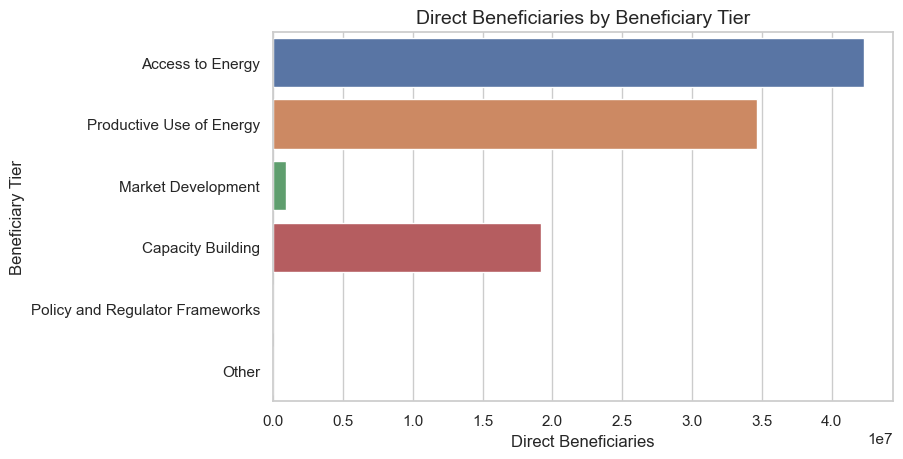

In [308]:
plotCategoryBeneficiaries("Beneficiary Tier")

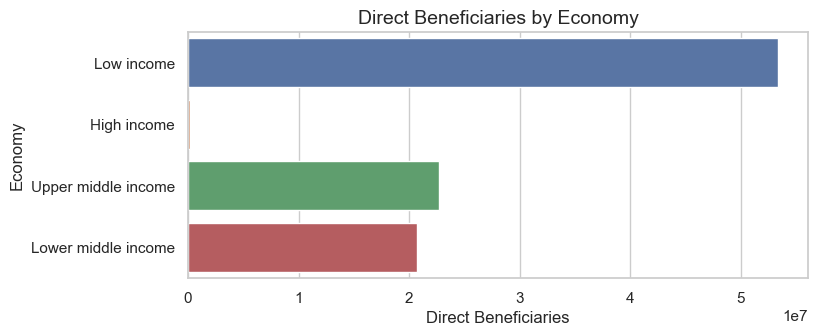

In [295]:
plotCategoryBeneficiaries("Economy")

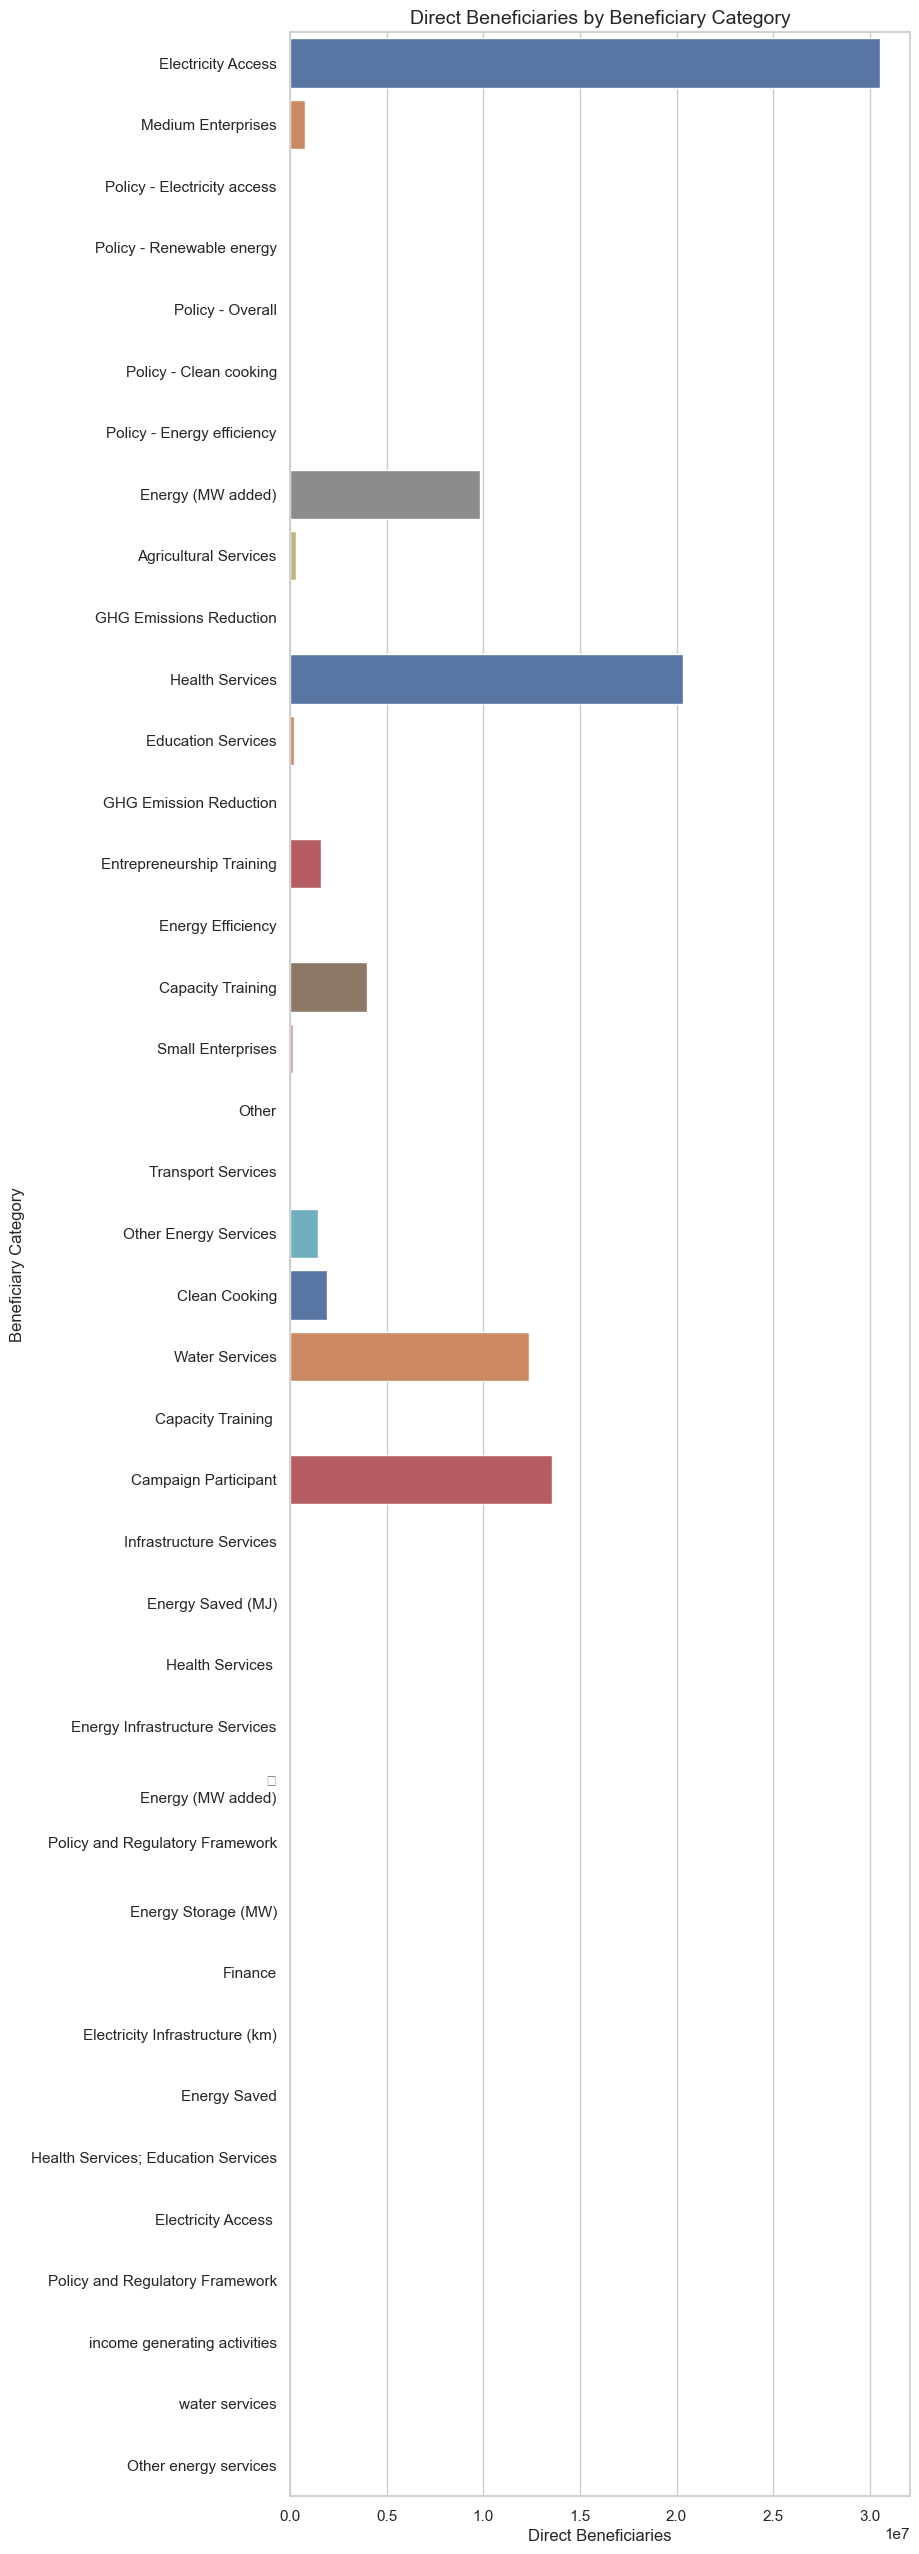

In [296]:
plotCategoryBeneficiaries("Beneficiary Category")

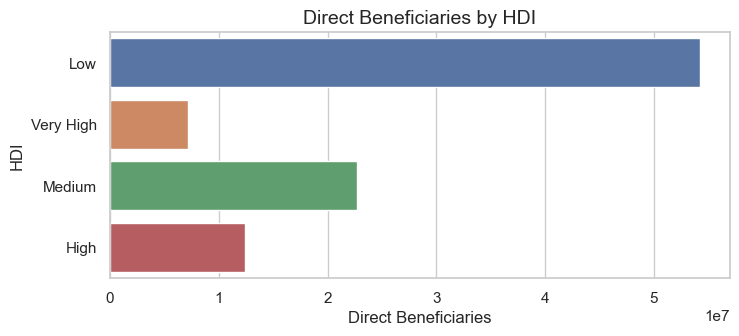

In [297]:
plotCategoryBeneficiaries("HDI")

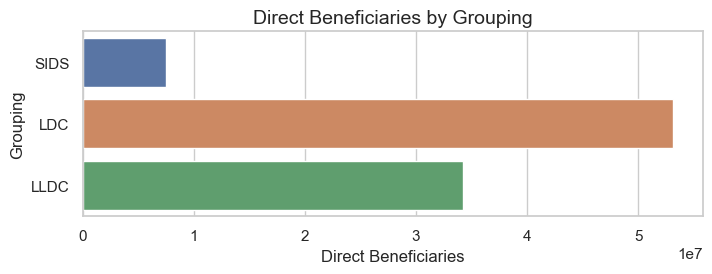

In [298]:
plotCategoryBeneficiaries("Grouping")

In [299]:
#df=df[df["Category"].isin(["Electricity Access","Energy (MW added)"])]

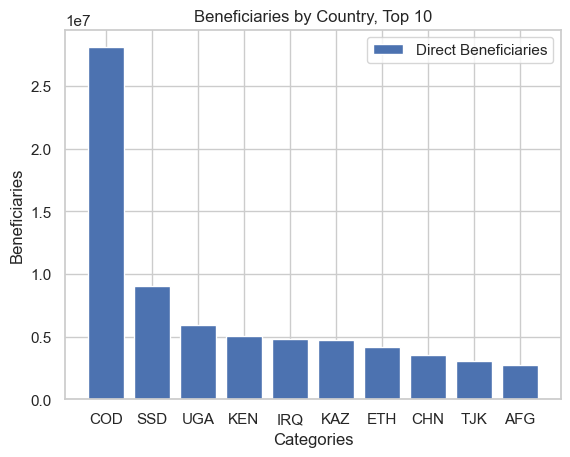

In [300]:
def plotCountryBeneficiaries():
    # Extract data from DataFrame
    df=updatedCountryMeta.nlargest(10, 'Direct Beneficiaries')
       
    x = df['Country Code']
    y1 = df['Direct Beneficiaries']
    #y2 = df['Indirect Beneficiaries']

    # Create the stacked bar chart
    plt.bar(x, y1, label='Direct Beneficiaries')
    #plt.bar(x, y2, bottom=y1, label='Indirect Beneficiaries')

    # Add labels and title
    plt.xlabel('Categories')
    plt.ylabel('Beneficiaries')
    plt.title("Beneficiaries by Country, Top 10")
    plt.legend()

    # Display the chart
    plt.show()

plotCountryBeneficiaries()

<h4> Donor analysis </h4>

In [301]:

# calculate donors stats (donors, beneficiaries)
# matplotlib


In [302]:
# projectDonors={}

# for project in projectDf["Project ID"]:
#     donorList=[]
#     for donor in projectDf["Donors"].split(",")
#         donor=donor.replace("'", "").replace("[", "").replace("]", "")

#         split=donor.split("$")
#         if len(split)>1:
#             if testNumeric(split[0]):
#                 val=split[0]
#                 donor=split[1]
#             else if testNumeric(split[1]):
#                 val=split[1]
#                 donor=split[0]
#             else:
#                 donor=split
#         donorList.append(donor)
#     projectDonors[project]=

<h4> Export xlsx with each df as a separate sheet </h4>

In [303]:
###Export full xlsx with all dfs as tabs
# Create ExcelWriter object
writer = pd.ExcelWriter('../02_Output/00_Final Results/Moonshot Tracker Results - Auto.xlsx', engine='xlsxwriter')

# Write DataFrames to separate sheets
summaryDf.to_excel(writer, sheet_name='Summary', index=False)
outputDfComplete.to_excel(writer, sheet_name='Outputs', index=False)
projectDf.to_excel(writer, sheet_name='Projects', index=False)
updatedCountryMeta.to_excel(writer, sheet_name='Countries', index=False)
#donorDf.to_excel(writer, sheet_name='Donors', index=False)

# Save the Excel file
writer.save()